In [1]:
import requests
import json
import pyTigerGraph as tg
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import csv
import os.path
from sklearn.decomposition import PCA

In [39]:
# On-premise
conn = tg.TigerGraphConnection(host="http://127.0.0.1",graphname="graph_drug_disease", username="tigergraph", password="tigergraph", apiToken="2aa016d747ede9gg6da3drslm98srfoj")


In [2]:
# Cloud
conn = tg.TigerGraphConnection(host="https://ddmp.i.tgcloud.io", graphname="graph_drug_disease")
authToken = conn.getToken("982l37jamamujrg5ing9cvh18mt0o9jn", "100000000000000000")
print(authToken)

('qn17c3cr3k00rg7hr6c7k2fh9sho8q52', 1653043928, '2022-05-20 10:52:08')


# Installing graph algorithm queries: random walk, node2vec

In [7]:
with open('queries/tg_random_walk_batch.gsql', 'r') as file:
    gsql_file = file.read().rstrip()
conn.gsql(gsql_file)
conn.gsql('INSTALL QUERY tg_random_walk_batch')

'Start installing queries, about 1 minute ...\ntg_random_walk_batch query: curl -X GET \'https://127.0.0.1:9000/query/graph_drug_disease/tg_random_walk_batch?batches=VALUE&step=VALUE&path_size=VALUE&[filepath=VALUE]&edge_types=VALUE&sample_num=VALUE\'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.\nSelect \'m1\' as compile server, now connecting ...\nNode \'m1\' is prepared as compile server.\n\nQuery installation finished.'

In [10]:
with open('queries/tg_node2vec.gsql', 'r') as file:
    gsql_file = file.read().rstrip()
conn.gsql(gsql_file)
conn.gsql('INSTALL QUERY tg_node2vec')

'\nType Check Error in query tg_node2vec (TYP-8016): line 2, col 3\nincompatible argument types for function/tuple tg_node2vec_sub\nFailed to create queries: [tg_node2vec].'

In [ ]:
# Testing queries

In [ ]:
#print(conn.gsql('RUN QUERY tg_random_walk_batch (8, 8, 5,_,"prescript_drug" , 8)'))
#print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 3, 3,"/home/tigergraph/path2.csv","prescript_drug" , 6)'))
#print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 4, 4,"/home/tigergraph/path2.csv","prescript_drug" , 6)'))
#print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 4, 4,"/home/tigergraph/paths_drug_gene_disease.csv",["is_prescripted_for","gene_disease_association","drug_gene_association"], 12)'))
print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 4, 4,"/home/tigergraph/paths_drug_disease-clinical_trials.csv","drug_is_tested_for", 12)'))


In [ ]:
#print(conn.gsql('RUN QUERY tg_node2vec ("/home/tigergraph/path2.csv","/home/tigergraph/emb2.csv", 8)'))
#print(conn.gsql('RUN QUERY tg_node2vec ("/home/tigergraph/paths_drug_gene_disease.csv","/home/tigergraph/emb_drug_gene_disease.csv", 8)'))
print(conn.gsql('RUN QUERY tg_node2vec ("/home/tigergraph/paths_drug_disease-clinical_trials.csv","/home/tigergraph/emb_paths_drug_disease-clinical_trials.csv", 8)'))

# Graph embbeding based on prescriber and drug

In [ ]:
df_emb = pd.read_csv("/home/tigergraph/emb2.csv", sep=' ', skiprows=[0], header=None)
df_emb.head(2)

In [ ]:
df_emb_prescriber = df_emb[df_emb[0].str.isnumeric().fillna(False)]
df_emb_prescriber = df_emb_prescriber.reset_index(drop=True)
df_emb_prescriber.head(2)

In [ ]:
features = df_emb_prescriber.drop(0, 1)
features

# Functions to process embedding, plot and find clusters

In [31]:
def features_to_pca(df_features):
    pca = PCA(n_components=2)
    pca.fit(df_features)
    pca_emb = pca.transform(df_features)
    return pca_emb
def plot_pca(pca_emb):
    plt.scatter(pca_emb[:,0], pca_emb[:,1])
    plt.show()
def knn(df_features, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto',  n_jobs=-1).fit(df_features)
    distances, indices = nbrs.kneighbors(df_features)
    return distances, indices
def discover_indices(df, indices, k):
    knn_dict = {}
    for array in indices:
        knn_list = []
        for i in range(1, k):
            knn_list.append(df.iloc[array[i],0])
        knn_dict[df.iloc[array[0],0]] = knn_list
    return knn_dict
def save_knn(filename, knn_dict):
    f = open(filename, "w")
    for key, value in knn_dict.items():    
        #print(key, value)
        list_str = ','.join(value)
        line = key + " " + list_str + "\n"
        f.write(line)
    f.close()
    print("saved")

In [ ]:
pca = features_to_pca(features)

In [ ]:
plot_pca(pca)

In [ ]:
distances, indices = knn(features, k)

In [ ]:
knn_dict = discover_indices(indices, k)

In [ ]:
save_knn("../results/knn_results/knn_prescriber_related_to_drug.csv", knn_dict)

In [ ]:
df_emb_drug = df_emb[df_emb[0].str.isalpha().fillna(False)]
df_emb_drug = df_emb_drug.reset_index(drop=True)
df_emb_drug

In [ ]:
features = df_emb_drug.drop(0, 1)
features

In [ ]:
pca = features_to_pca(features)
pca

In [ ]:
plot_pca(pca)

In [ ]:
k=10
distances, indices = knn(features, k)

In [ ]:
knn_dict = discover_indices(df_emb_drug, indices, k)

In [ ]:
i=0
for key, value in knn_dict.items():
    if(i<10):
        print(key, value)
    i += 1

In [ ]:
save_knn("../results/knn_results/knn_drug_related_to_prescriber.csv", knn_dict)

# Graph embbeding based on disease, gene and drug

In [22]:
print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 4, 4,"/home/tigergraph/paths_drug_disease.csv","is_prescripted_for", 12)'))
print(conn.gsql('RUN QUERY tg_node2vec ("/home/tigergraph/paths_drug_disease.csv","/home/tigergraph/emb_drug_disease.csv", 8)'))

{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}
{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}


In [23]:
df_emb = pd.read_csv("/home/tigergraph/emb_drug_disease.csv", delim_whitespace=True, error_bad_lines=False, skiprows=[0, 74997], header=None)
df_emb

,0,1,2,3,4,5,6,7,8
0,BREAST_NEOPLASMS,0.988187,-0.023418,0.163887,-0.278669,-0.189666,-0.200856,-2.434340,1.246850
1,"CARCINOMA,_HEPATOCELLULAR",-1.670750,-0.979863,0.112609,-0.185665,-1.528230,-0.180103,-1.473530,1.018590
2,CHEMICAL_AND_DRUG_INDUCED_LIVER_INJURY,-1.632710,0.504750,1.435650,0.012268,0.417384,-0.425025,-0.191668,1.502800
3,PROSTATIC_NEOPLASMS,-1.498110,-0.826031,0.465680,-0.011669,-0.284424,-1.279580,-0.820377,0.935991
4,OBESITY,-0.551522,-0.528052,0.255899,-1.629940,-0.774520,0.427481,-1.437480,0.456917
...,...,...,...,...,...,...,...,...,...
24013,TRICHOPHYTON_INFECTION,-0.248832,-0.107510,-0.243523,-0.287661,0.563716,-0.273799,0.053485,0.497328
24014,CHOLERA,-0.220122,0.270768,0.034328,-0.225832,0.239347,-0.124676,0.019994,0.445454
24015,MARCUS_GUNN_PHENOMENON,-0.201724,0.237354,0.054556,-0.494769,0.127318,-0.087461,-0.208350,0.359160
24016,DI-ALLATE,-0.170816,0.201077,0.026871,-0.257755,0.323521,0.002180,0.134155,0.663299


In [24]:
folder = "../data_for_graph/"
filename = "diseases/diseases.csv"
df_diseases = pd.read_csv(folder+filename, sep=" ",header=None)

df_diseases = df_diseases[df_diseases[0].notna()]
df_diseases

,0
1,HEMATOLOGIC_DISEASES
2,"MANDIBULOFACIAL_DYSOSTOSIS,_TREACHER_COLLINS_T..."
3,_GONADAL_TISSUE
4,"NEOPLASM_RECURRENCE,_LOCAL"
5,"HEARING_LOSS,_SENSORINEURAL"
...,...
7911,PANCREATIC_PSEUDOCYST
7912,"LYMPHOMA,_PRIMARY_EFFUSION"
7913,"DYSENTERY,_AMEBIC"
7914,HYDROXYKYNURENINURIA


In [25]:
df_diseases_emb = pd.merge(left=df_diseases, right=df_emb, left_on=0, right_on=0)
df_diseases_emb

,0,1,2,3,4,5,6,7,8
0,HEMATOLOGIC_DISEASES,-1.235980,-0.240802,0.053693,-1.350490,-0.081065,0.271478,-0.312331,0.674018
1,"MANDIBULOFACIAL_DYSOSTOSIS,_TREACHER_COLLINS_T...",-0.255803,-0.143101,-2.172340,-0.768516,-0.193506,-0.559631,-0.370477,0.195836
2,"NEOPLASM_RECURRENCE,_LOCAL",-0.631504,-0.396580,-0.068793,-1.002540,-0.077358,-0.647138,-0.598450,0.980214
3,"HEARING_LOSS,_SENSORINEURAL",-1.085510,0.999426,-0.160989,-0.680408,0.276418,-0.190416,-0.629465,0.116105
4,STRIATONIGRAL_DEGENERATION,-0.236907,-0.140161,-0.292686,-0.506454,1.676430,-0.293738,1.129270,0.577930
...,...,...,...,...,...,...,...,...,...
7253,PANCREATIC_PSEUDOCYST,-0.511236,0.431645,-0.129180,-1.292260,1.151030,-0.420478,1.104760,0.481006
7254,"LYMPHOMA,_PRIMARY_EFFUSION",-0.894729,-0.205168,-0.682903,-1.853950,0.913493,-0.534022,0.631599,0.055197
7255,"DYSENTERY,_AMEBIC",-0.412255,0.277319,0.046138,-0.441086,0.709650,-0.216635,-0.432673,0.279040
7256,HYDROXYKYNURENINURIA,-0.556926,-0.216269,-0.591721,-0.992093,1.220350,0.188994,-0.060012,-0.022017


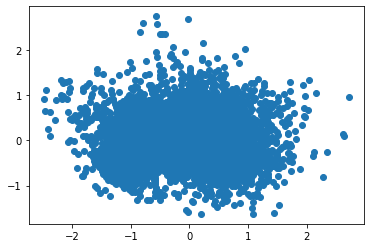

HEMATOLOGIC_DISEASES ['METHYLMALONIC_ACIDURIA_CBLB_TYPE', 'PSEUDOHYPOPARATHYROIDISM_TYPE_1B', 'ANEMIA,_SIDEROBLASTIC,_PYRIDOXINE-REFRACTORY,_AUTOSOMAL_RECESSIVE', 'BLASTOMYCOSIS', 'SEBACEOUS_GLAND_NEOPLASMS', 'MICROPHTHALMIA,_ISOLATED,_WITH_COLOBOMA_10', 'WERNICKE_ENCEPHALOPATHY', 'PANCYTOPENIA', 'THYROID_DYSHORMONOGENESIS_4']
MANDIBULOFACIAL_DYSOSTOSIS,_TREACHER_COLLINS_TYPE,_AUTOSOMAL_RECESSIVE ['DYSKERATOSIS_CONGENITA,_AUTOSOMAL_DOMINANT_3', 'ATRIAL_FIBRILLATION,_FAMILIAL,_11', 'NANOPHTHALMOS_2', 'INTELLECTUAL_DEVELOPMENTAL_DISORDER,_X-LINKED,_SYNDROMIC,_NASCIMENTO_TYPE', 'INSULINOMA', 'THROMBOPHILIA,_FAMILIAL,_DUE_TO_DECREASED_RELEASE_OF_TISSUE_PLASMINOGEN_ACTIVATOR_THPH9_HYPERFIBRINOLYSIS,_FAMILIAL,_DUE_TO_INCREASED_RELEASE_OF_TISSUE_PLASMINOGEN', 'GAS_POISONING', 'CUTIS_LAXA_WITH_SEVERE_PULMONARY,_GASTROINTESTINAL,_AND_URINARY_ABNORMALITIES', 'AMELOGENESIS_IMPERFECTA,_TYPE_IH']
NEOPLASM_RECURRENCE,_LOCAL ['HYPOSPADIAS', 'WAARDENBURG_SYNDROME,_TYPE_4', 'ALZHEIMER_DISEASE_18', 'MIG

In [32]:
# disease
features = df_diseases_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_diseases_emb, indices, k)


i=0
for key, value in knn_dict.items():
    if(i<5):
        print(key, value)
    i += 1

save_knn("../results/knn_results/knn_disease_related_to_drug.csv", knn_dict)

In [33]:
folder = "../data_for_graph/"
filename = "drugs/drugs.csv"
df_drugs = pd.read_csv(folder+filename, sep=" ", header=None)
df_drugs

,0
0,NEUPRO_4MG/24HR_TRANSDERMAL_PATCH
1,MK-8892
2,COCKTAIL_FROM_COMPLEX_PHYTOADAPTOGENS_(CFA)
3,CURODONT_D_SENZ
4,USTEKINUMAB_90_MG_SC_Q12W
...,...
62595,ENDODONTIC_TREATMENT_USING_VITAPEX
62596,PLACEBO_OF_ARTEMISIA_HERB_95%_ETHANOL_SOFT_EXT...
62597,NEOADJUVANT_DOCETAXEL/CISPLATIN
62598,DNAJ_PEPTIDE


In [34]:
df_drug_emb = pd.merge(left=df_drugs, right=df_emb, left_on=0, right_on=0)
df_drug_emb

,0,1,2,3,4,5,6,7,8
0,ACETIC_ANHYDRIDE,-1.063120,-0.206048,-0.075932,0.233074,0.559543,-0.167654,-0.376337,-0.587713
1,CANDOXATRILAT,-0.120275,0.199988,-0.245954,-0.266510,1.112190,-0.129742,0.141846,0.525802
2,CYSTEINYL-ARGINYL-TYROSYL-PROLYL-GLUTAMYL-VALY...,0.648875,-0.802864,0.770518,0.759837,0.267263,0.000083,-0.992870,1.725610
3,BISDEQUALINIUM,0.643144,0.601628,0.004580,0.346293,-0.413864,1.018840,-0.721951,1.574970
4,"N,N-DIMETHYLHISTAMINE",-0.703219,0.029475,-0.319033,-0.267943,0.313326,1.516480,-0.584421,0.112278
...,...,...,...,...,...,...,...,...,...
16755,CRYPTOLEPINE,-0.080134,-0.557283,-0.176689,-0.573433,0.835891,-0.244161,-0.151910,0.213095
16756,AMANTADINE,-0.751593,0.670046,-0.541953,0.340565,0.907458,0.139072,-0.763024,0.117438
16757,ZINOSTATIN,-0.180909,-0.317092,-0.652713,-0.090609,-0.016180,-0.133372,-0.793287,0.556763
16758,"5-OH,11-O-HYDROPHENANTHRENE",-1.108170,-0.217801,0.136984,-0.246684,1.123030,1.093750,-0.022544,1.438310


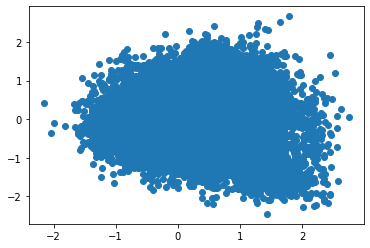

ACETIC_ANHYDRIDE ['LYCORINE', 'CETYLPYRIDINIUM', 'GW_506033X', 'LEUKADHERIN-1', 'SELENOMETHIONINE', 'SAUCHINONE', 'CP_105696', 'WATER', '4-METHYLCATECHOL']
CANDOXATRILAT ['N_1_,N_11_-DIETHYLNORSPERMINE', '_1,2,5,6-TETRAHYDROPYRIDIN-4-YL_METHYLPHOSPHINIC_ACID', 'EQUILENIN', '2_,3_-DIDEOXYGUANOSINE_5_-TRIPHOSPHATE', 'BMS-906024', 'AL-10_COMPOUND', 'SHIKIMIC_ACID', 'CAV_PROTOCOL', 'PHENYLENEDIAMINES']
saved


In [35]:
# drug

features = df_drug_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_drug_emb, indices, k)


i=0
for key, value in knn_dict.items():
    if(i<2):
        print(key, value)
    i += 1

save_knn("../results/knn_results/knn_drug_related_to_disease.csv", knn_dict)

# Graph embbeding based on gene and drug

In [36]:
print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 4, 4,"/home/tigergraph/paths_drug_gene.csv",["drug_gene_association"], 12)'))
print(conn.gsql('RUN QUERY tg_node2vec ("/home/tigergraph/paths_drug_gene.csv","/home/tigergraph/emb_drug_gene.csv", 8)'))

{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}
{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}


In [81]:
df_emb = pd.read_csv("/home/tigergraph/emb_drug_gene.csv", delim_whitespace=True, error_bad_lines=False, skiprows=[0, 74997], header=None)
df_emb

,0,1,2,3,4,5,6,7,8
0,BISPHENOL_A,0.862124,0.310866,1.060710,0.852102,-1.334220,-0.448803,1.466160,1.096090
1,BENZO(A)PYRENE,1.097660,-0.335064,0.567130,0.939244,-0.419588,0.455286,1.471440,1.934490
2,AFLATOXIN_B1,1.239640,0.051731,0.707586,0.945019,-0.862627,0.285871,1.570190,1.786960
3,TOBACCO_SMOKE_POLLUTION,0.853328,-0.183226,-0.794152,0.918770,-1.159890,1.016050,1.467630,1.015040
4,SODIUM_ARSENITE,1.317580,0.134462,0.777013,0.651909,-1.395350,-0.509610,1.177900,0.457564
...,...,...,...,...,...,...,...,...,...
67587,POLYGLUTAMINE,-0.410817,-0.503930,0.017912,0.450070,-0.002021,-0.063579,0.283299,-0.427225
67588,53585,-0.396409,-0.437211,0.054024,0.493883,0.025618,-0.046411,0.315040,-0.381679
67589,FM1_43,-0.042556,-0.680421,-0.022115,0.790251,-0.077667,0.395072,-0.046393,-0.081005
67590,FLUOR-FOLPET,-0.397994,-0.481787,0.302947,0.302326,0.174941,-0.007055,0.171621,-0.065320


In [69]:
# Install getListGENES query to list all genes
with open('queries/getListGENES.gsql', 'r') as file:
    gsql_file = file.read().rstrip()
conn.gsql(gsql_file)
conn.gsql('INSTALL QUERY getListGENES')

'Successfully created queries: [getListGENES].'

In [74]:
conn.gsql("RUN QUERY getListGENES()")


'{\n"error": false,\n"message": "",\n"version": {\n"schema": 0,\n"edition": "enterprise",\n"api": "v2"\n},\n"results": []\n}'

In [76]:
getGENES = []
with open("/home/tigergraph/getGENES.txt") as file:
    for line in file: 
        line = line.strip() #or some other preprocessing
        getGENES.append(line) #storing everything in memory!
df_genes = pd.DataFrame(getGENES)
len(getGENES)
df_genes

,0
0,8731
1,4829
2,79670
3,2001
4,1543
...,...
537926,13192904
537927,13179534
537928,13220852
537929,13214708


In [82]:
df_gene_emb = pd.merge(left=df_genes, right=df_emb, left_on=0, right_on=0)
df_gene_emb.head(2)

,0,1,2,3,4,5,6,7,8
0,8731,0.277026,-0.186327,0.064542,-0.037710,0.384512,-0.039527,0.043941,-0.389886
1,4829,0.461700,-0.332953,0.072047,0.280494,-0.176056,0.416715,0.363393,-0.067812


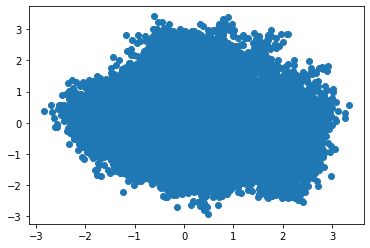

saved


In [83]:
# gene
features = df_gene_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_gene_emb, indices, k)

save_knn("../results/knn_results/knn_gene_related_to_drug.csv", knn_dict)

In [51]:
df_drug_emb = pd.merge(left=df_drugs, right=df_emb, left_on=0, right_on=0)
df_drug_emb

,0,1,2,3,4,5,6,7,8
0,ACETIC_ANHYDRIDE,-1.063120,-0.206048,-0.075932,0.233074,0.559543,-0.167654,-0.376337,-0.587713
1,CANDOXATRILAT,-0.120275,0.199988,-0.245954,-0.266510,1.112190,-0.129742,0.141846,0.525802
2,CYSTEINYL-ARGINYL-TYROSYL-PROLYL-GLUTAMYL-VALY...,0.648875,-0.802864,0.770518,0.759837,0.267263,0.000083,-0.992870,1.725610
3,BISDEQUALINIUM,0.643144,0.601628,0.004580,0.346293,-0.413864,1.018840,-0.721951,1.574970
4,"N,N-DIMETHYLHISTAMINE",-0.703219,0.029475,-0.319033,-0.267943,0.313326,1.516480,-0.584421,0.112278
...,...,...,...,...,...,...,...,...,...
16755,CRYPTOLEPINE,-0.080134,-0.557283,-0.176689,-0.573433,0.835891,-0.244161,-0.151910,0.213095
16756,AMANTADINE,-0.751593,0.670046,-0.541953,0.340565,0.907458,0.139072,-0.763024,0.117438
16757,ZINOSTATIN,-0.180909,-0.317092,-0.652713,-0.090609,-0.016180,-0.133372,-0.793287,0.556763
16758,"5-OH,11-O-HYDROPHENANTHRENE",-1.108170,-0.217801,0.136984,-0.246684,1.123030,1.093750,-0.022544,1.438310


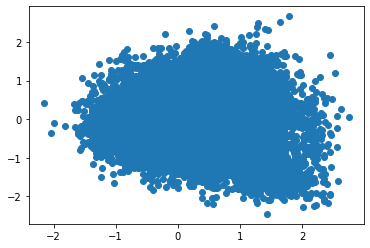

saved


In [53]:
# drug

features = df_drug_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_drug_emb, indices, k)

save_knn("../results/knn_results/knn_drug_related_to_gene.csv", knn_dict)

# Graph embbeding based on drug, disease in clinical trials

In [54]:
print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 4, 4,"/home/tigergraph/paths_drug_clinical_trial.csv",["drug_is_tested_for"], 12)'))
print(conn.gsql('RUN QUERY tg_node2vec ("/home/tigergraph/paths_drug_clinical_trial.csv","/home/tigergraph/emb_drug_clinical_trial.csv", 8)'))

{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}
{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}


In [58]:
df_emb = pd.read_csv("/home/tigergraph/emb_drug_clinical_trial.csv", sep=' ', skiprows=[0], header=None)
df_emb

,0,1,2,3,4,5,6,7,8
0,PATHOLOGIC_PROCESSES,-0.764001,1.599140,-0.132291,0.383931,0.740883,-0.690623,-0.233427,-0.700170
1,NEOPLASMS,0.272610,0.798054,0.210057,1.562960,-2.017630,-0.607244,-0.612113,-0.212308
2,NERVOUS_SYSTEM,-0.103563,0.474360,0.421163,-0.445478,0.101421,-0.457954,-0.974456,-0.324047
3,IMMUNE_SYSTEM,1.664590,0.991181,0.453310,0.924397,-0.449275,0.196892,0.614049,-1.475910
4,DIGESTIVE_SYSTEM,-0.473119,0.266885,-1.076650,1.605450,-0.333403,-0.953094,-0.254454,-0.678347
...,...,...,...,...,...,...,...,...,...
48818,PLACEBO/CANNABIDIOL,-1.202010,0.994687,-0.044625,0.247698,0.320957,-1.672340,-1.320160,-0.972477
48819,OMEGA-3_LONG_CHAIN_FATTY_ACID,-0.908258,0.686126,-0.076869,0.016510,0.269474,-1.269860,-1.341690,0.106433
48820,RISPERIDAL_CONSTA,-0.495965,1.365200,-0.433185,0.585842,-0.290075,-1.543660,-1.608300,-0.775708
48821,HAND_INJURIES,0.476116,0.404291,0.152420,-0.023470,0.209968,-0.108821,-0.078717,-0.324532


In [56]:
df_diseases_emb = pd.merge(left=df_diseases, right=df_emb, left_on=0, right_on=0)
df_diseases_emb

,0,1,2,3,4,5,6,7,8
0,_GONADAL_TISSUE,-0.508984,0.049437,0.283112,0.642622,-0.697086,-0.003301,-0.769689,-0.999105
1,SALMONELLA_INFECTIONS,-0.148270,0.214053,0.251835,0.962789,1.180030,-0.262720,-0.746154,-0.879587
2,THROMBOPHILIA,0.717136,0.556401,0.484458,0.258413,-0.412320,-1.092140,0.707538,-0.560637
3,CHOLELITHIASIS,-1.018230,0.534436,-0.010332,0.764324,-0.323575,-0.777671,-0.447560,-0.752336
4,_T-CELL,0.314388,0.309179,0.135293,0.466244,-0.857191,-0.112498,-0.277523,-0.943055
...,...,...,...,...,...,...,...,...,...
1286,LIPID_METABOLISM,1.475660,1.619800,0.192715,-1.060870,-0.192242,-1.167880,-0.425649,0.043515
1287,FACIAL_INJURIES,-0.616993,0.805884,0.865981,-0.586579,0.350231,-0.520218,-0.842986,-1.144560
1288,PERIPHERAL_VASCULAR,-0.536257,1.654350,-0.582709,-0.211495,0.146306,-0.317400,0.364383,-0.307002
1289,RESPIRATORY_SOUNDS,-0.399330,2.030540,-0.423696,-0.468973,0.538802,-0.276678,0.336057,-0.665192


In [ ]:
# disease

features = df_diseases_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_diseases_emb, indices, k)


i=0
for key, value in knn_dict.items():
    if(i<2):
        print(key, value)
    i += 1

save_knn("../results/knn_results/knn_disease_related_to_clinical_trials.csv", knn_dict)

In [57]:
df_drug_emb = pd.merge(left=df_drugs, right=df_emb, left_on=0, right_on=0)
df_drug_emb

,0,1,2,3,4,5,6,7,8
0,NEUPRO_4MG/24HR_TRANSDERMAL_PATCH,0.249123,0.489236,1.043030,-0.144578,0.207953,-2.398570,-1.259820,0.602199
1,MK-8892,-0.580507,1.301480,-1.292680,0.040475,0.108030,-0.866204,1.288270,-0.916650
2,COCKTAIL_FROM_COMPLEX_PHYTOADAPTOGENS_(CFA),-0.791861,0.302670,1.483300,1.051370,0.120004,0.117602,-0.815434,-1.713930
3,CURODONT_D_SENZ,-1.011290,-0.168487,1.492180,1.000600,0.763555,-0.002081,-0.488803,-0.371497
4,USTEKINUMAB_90_MG_SC_Q12W,-1.541310,-0.146845,-0.289706,1.485560,-0.097485,-0.526455,-0.040460,-0.586106
...,...,...,...,...,...,...,...,...,...
47527,ENDODONTIC_TREATMENT_USING_VITAPEX,-1.415100,0.370126,2.215370,1.401760,0.785475,-0.029752,-0.725356,-0.546330
47528,PLACEBO_OF_ARTEMISIA_HERB_95%_ETHANOL_SOFT_EXT...,-0.863770,0.281317,-0.446147,2.178170,0.450209,-0.727373,-0.569186,0.699007
47529,NEOADJUVANT_DOCETAXEL/CISPLATIN,1.282590,0.509680,-0.109675,2.193890,-0.994564,0.254877,0.125937,1.040180
47530,DNAJ_PEPTIDE,0.582381,1.489760,1.658710,-0.070390,0.081657,0.819063,-0.559598,-0.840697


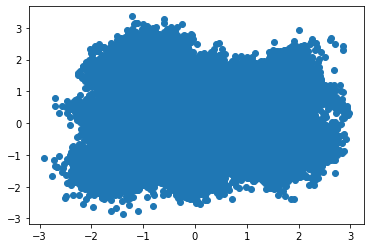

saved


In [59]:
# drug 
features = df_drug_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_drug_emb, indices, k)



save_knn("../results/knn_results/knn_drug_related_to_clinical_trials.csv", knn_dict)

# Create embeding based on gene disease association

In [60]:
print(conn.gsql('RUN QUERY tg_random_walk_batch (1, 4, 4,"/home/tigergraph/paths_disease_gene.csv","gene_disease_association", 12)'))
print(conn.gsql('RUN QUERY tg_node2vec ("/home/tigergraph/paths_disease_gene.csv","/home/tigergraph/emb_disease_gene.csv", 8)'))

{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}
{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": []
}


In [62]:
df_emb = pd.read_csv("/home/tigergraph/emb_disease_gene.csv", sep=' ', skiprows=[0], header=None)
df_emb

,0,1,2,3,4,5,6,7,8
0,POISONING,-0.125674,-1.145970,-0.179170,-0.825292,-2.615540,-0.469768,-0.433720,-0.786769
1,CHEMICAL_AND_DRUG_INDUCED_LIVER_INJURY,-0.038632,0.168071,-0.104346,-1.466240,-2.086070,0.061337,-0.745110,-0.341108
2,"DISEASE_MODELS,_ANIMAL",-2.139230,-1.140410,-0.920574,-0.930372,-1.206080,-0.858973,0.269302,-0.010597
3,PRENATAL_EXPOSURE_DELAYED_EFFECTS,-0.856311,-0.344572,-0.447489,-1.697040,-1.973560,-0.792163,-0.592068,0.014354
4,MEMORY_DISORDERS,0.127555,-1.154090,-0.716306,-2.239240,-1.355980,-1.483500,-0.940702,0.604181
...,...,...,...,...,...,...,...,...,...
60385,HUMAN_PAPILLOMAVIRUS_TYPE_18_INTEGRATION_SITE_2,0.022687,0.112669,-0.288733,0.074408,-0.248148,-0.449585,-0.401519,-0.137197
60386,1888,0.015187,0.090395,0.011759,-0.075137,-0.280241,-0.367722,0.260312,-0.072022
60387,HUMAN_PAPILLOMAVIRUS_TYPE_18_INTEGRATION_SITE_1,0.231076,0.157088,0.433480,-0.326345,-0.189546,0.440893,0.112501,-0.019223
60388,CEREBELLAR_DEGENERATION-RELATED_AUTOANTIGEN_3,-0.086714,0.282162,0.215148,-0.147257,-0.235880,0.283155,-0.014794,-0.231815


In [63]:
df_diseases_emb = pd.merge(left=df_diseases, right=df_emb, left_on=0, right_on=0)
df_diseases_emb

,0,1,2,3,4,5,6,7,8
0,HEMATOLOGIC_DISEASES,-1.912130,-1.451720,-0.704618,-0.666442,0.017121,-0.539418,0.280258,-0.830800
1,"MANDIBULOFACIAL_DYSOSTOSIS,_TREACHER_COLLINS_T...",0.398595,0.423514,0.873508,0.828987,0.732811,-0.087584,-0.519259,-0.910074
2,"NEOPLASM_RECURRENCE,_LOCAL",-0.006587,-0.011055,-0.714940,-0.821880,-0.317458,1.112140,0.260802,-0.035405
3,"HEARING_LOSS,_SENSORINEURAL",-0.612409,-0.396527,-0.759464,-0.743206,-0.957644,0.537091,0.034073,-0.631775
4,STRIATONIGRAL_DEGENERATION,-0.123533,-0.235055,-1.097230,-0.886398,-0.069396,0.610476,-0.102876,-0.373663
...,...,...,...,...,...,...,...,...,...
7195,PANCREATIC_PSEUDOCYST,0.163316,-0.333689,-0.638396,-0.672760,-0.969740,-0.208398,1.850390,-0.391155
7196,"LYMPHOMA,_PRIMARY_EFFUSION",0.176289,0.139931,-0.655340,-0.833236,0.693694,0.829974,0.301575,-0.406991
7197,"DYSENTERY,_AMEBIC",-0.001679,-0.120925,-0.782812,-0.667010,0.166757,0.215720,0.309287,-0.533746
7198,HYDROXYKYNURENINURIA,-0.370622,0.927051,1.022930,0.467312,0.678623,0.195135,-0.225187,-1.540640


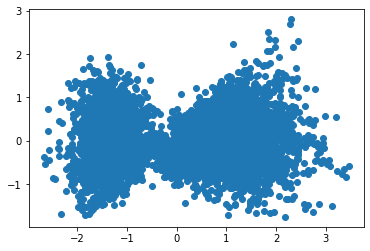

saved


In [64]:
# disease

features = df_diseases_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_diseases_emb, indices, k)


save_knn("../results/knn_results/knn_disease_related_to_gene.csv", knn_dict)

In [79]:
df_gene_emb = pd.merge(left=df_genes, right=df_emb, left_on=0, right_on=0)
df_gene_emb.head(2)

,0,1,2,3,4,5,6,7,8
0,8731,-0.064267,-0.151123,-0.615462,-0.600354,0.042663,0.668601,0.222163,-0.248708
1,4829,-0.789485,-1.067440,-0.267099,-0.687097,0.063150,-0.688032,0.325623,-0.349043


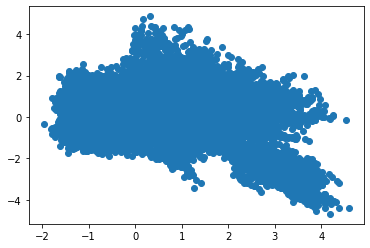

saved


In [80]:
# gene
features = df_gene_emb.drop(0, 1)
pca = features_to_pca(features)
plot_pca(pca)
k=10
distances, indices = knn(features, k)
knn_dict = discover_indices(df_gene_emb, indices, k)

save_knn("../results/knn_results/knn_gene_related_to_disease.csv", knn_dict)